In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("sales_data.csv")
df.head()


,date,product_id,store_id,category,units_sold,price,cost,discount_pct,is_promotion,is_holiday,inventory_level,competitor_price,weather_temp,day_of_week,week_of_year,month
0,2022-01-01,P101,S1,Electronics,95,96.06,71.70,20,1,0,171,89.45,11.7,5,52,1
1,2022-01-01,P101,S2,Electronics,209,31.43,22.95,20,1,1,463,29.62,15.5,5,52,1
2,2022-01-01,P101,S3,Electronics,99,68.93,41.46,0,0,0,108,67.55,11.4,5,52,1
3,2022-01-01,P102,S1,Electronics,44,56.49,42.76,10,1,0,293,57.53,11.4,5,52,1
4,2022-01-01,P102,S2,Electronics,54,56.04,33.77,0,0,1,291,54.76,10.5,5,52,1


In [2]:
def create_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['product_id','store_id','date'])

    # Lag features
    df['lag_1'] = df.groupby(['product_id','store_id'])['units_sold'].shift(1)
    df['lag_7'] = df.groupby(['product_id','store_id'])['units_sold'].shift(7)

    # Rolling window features
    df['rolling_mean_7'] = (
        df.groupby(['product_id','store_id'])['units_sold']
        .rolling(7).mean().reset_index(level=[0,1], drop=True)
    )

    df['rolling_mean_14'] = (
        df.groupby(['product_id','store_id'])['units_sold']
        .rolling(14).mean().reset_index(level=[0,1], drop=True)
    )

    df['rolling_mean_30'] = (
        df.groupby(['product_id','store_id'])['units_sold']
        .rolling(30).mean().reset_index(level=[0,1], drop=True)
    )

    # Price features
    df['price_diff'] = df['price'] - df['competitor_price']
    df['margin'] = df['price'] - df['cost']

    return df.dropna()


In [3]:
df_fe = create_features(df)

X = df_fe.drop(columns=['units_sold','date'])
y = df_fe['units_sold']

X.head()


,product_id,store_id,category,price,cost,discount_pct,is_promotion,is_holiday,inventory_level,competitor_price,...,day_of_week,week_of_year,month,lag_1,lag_7,rolling_mean_7,rolling_mean_14,rolling_mean_30,price_diff,margin
435,P101,S1,Electronics,90.53,64.90,0,0,0,341,82.90,...,6,4,1,104.0,111.0,96.285714,94.642857,88.066667,7.63,25.63
450,P101,S1,Electronics,88.34,61.68,5,1,1,145,95.89,...,0,5,1,108.0,108.0,110.428571,105.714286,91.800000,-7.55,26.66
465,P101,S1,Electronics,99.34,70.35,15,1,0,257,98.40,...,1,5,2,207.0,145.0,107.714286,106.214286,93.033333,0.94,28.99
480,P101,S1,Electronics,94.70,69.77,0,0,0,352,94.24,...,2,5,2,126.0,51.0,112.571429,107.142857,93.166667,0.46,24.93
495,P101,S1,Electronics,53.60,32.26,10,1,0,395,58.39,...,3,5,2,85.0,109.0,114.000000,112.785714,94.833333,-4.79,21.34


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
categorical_cols = ['product_id','store_id','category']

numeric_cols = [
    'price','cost','discount_pct','is_promotion','is_holiday',
    'inventory_level','competitor_price','weather_temp',
    'day_of_week','week_of_year','month',
    'lag_1','lag_7',
    'rolling_mean_7','rolling_mean_14','rolling_mean_30',
    'price_diff','margin'
]


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=400,
        max_depth=20,
        min_samples_leaf=5,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    ))
])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [6]:
pipeline.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


Mean Absolute Error: 30.666758853903037
Root Mean Squared Error: 36.69710392541052


In [14]:
results = X_test.copy()
results['actual_demand'] = y_test.values
results['predicted_demand'] = y_pred

results.head()


,product_id,store_id,category,price,cost,discount_pct,is_promotion,is_holiday,inventory_level,competitor_price,...,month,lag_1,lag_7,rolling_mean_7,rolling_mean_14,rolling_mean_30,price_diff,margin,actual_demand,predicted_demand
447,P105,S1,Fashion,79.33,55.41,15,1,0,493,77.13,...,1,24.0,110.0,86.857143,77.428571,81.833333,2.20,23.92,123,105.509959
462,P105,S1,Fashion,23.32,16.96,10,1,0,196,21.88,...,1,123.0,96.0,88.428571,78.428571,84.000000,1.44,6.36,107,88.266586
477,P105,S1,Fashion,31.03,22.89,5,1,0,258,28.40,...,2,107.0,135.0,85.142857,84.642857,85.466667,2.63,8.14,112,90.799828
492,P105,S1,Fashion,53.59,37.48,0,0,0,286,54.29,...,2,112.0,52.0,87.285714,85.214286,83.900000,-0.70,16.11,67,62.106796
507,P105,S1,Fashion,61.89,40.27,0,0,0,397,58.11,...,2,67.0,130.0,75.285714,84.071429,82.433333,3.78,21.62,46,63.350286


In [15]:

results.to_csv("demand_predictions.csv", index=False)

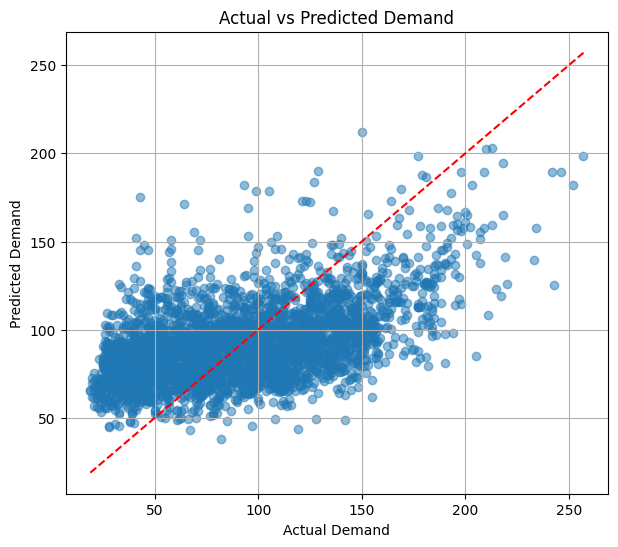

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.scatter(y_test, preds, alpha=0.5)

plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='red',
    linestyle='--'
)

plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.grid(True)

plt.show()


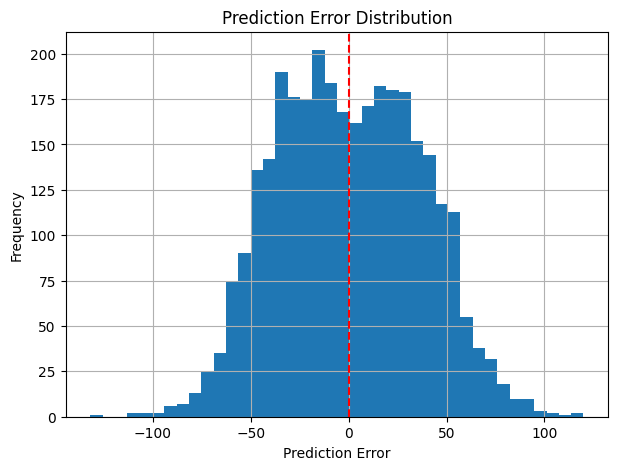

In [17]:
errors = y_test - y_pred

plt.figure(figsize=(7,5))
plt.hist(errors, bins=40)
plt.axvline(0, color='red', linestyle='--')

plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")
plt.grid(True)
plt.show()


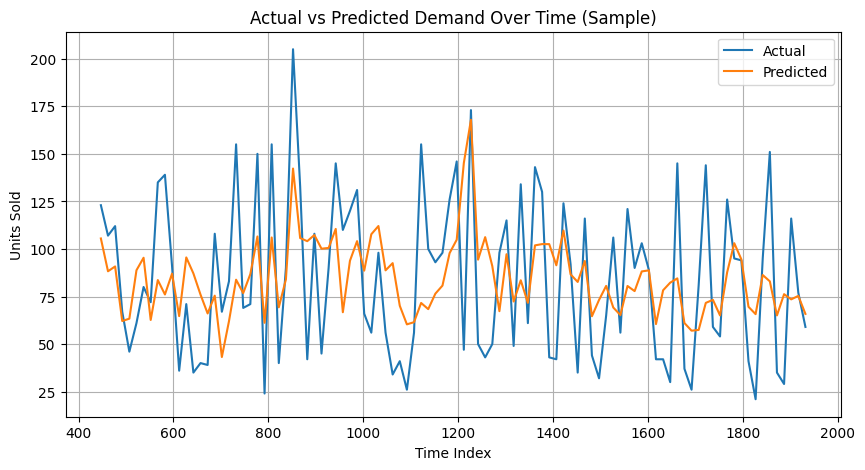

In [18]:
sample_idx = y_test.index[:100]

plt.figure(figsize=(10,5))
plt.plot(sample_idx, y_test.loc[sample_idx], label="Actual")
plt.plot(sample_idx, y_pred[:100], label="Predicted")

plt.xlabel("Time Index")
plt.ylabel("Units Sold")
plt.title("Actual vs Predicted Demand Over Time (Sample)")
plt.legend()
plt.grid(True)
plt.show()


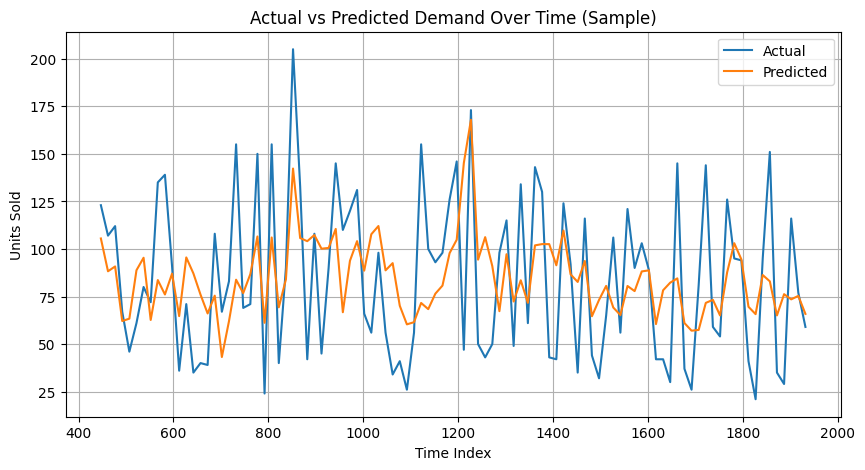

In [19]:
sample_idx = y_test.index[:100]

plt.figure(figsize=(10,5))
plt.plot(sample_idx, y_test.loc[sample_idx], label="Actual")
plt.plot(sample_idx, y_pred[:100], label="Predicted")

plt.xlabel("Time Index")
plt.ylabel("Units Sold")
plt.title("Actual vs Predicted Demand Over Time (Sample)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
plt.savefig("actual_vs_predicted.png")


<Figure size 640x480 with 0 Axes>